# GPU

Le calcul sur GPU permet de calculer plus rapidement certaines opérations mathématiques.
Il est particulièrement bien adapté pour les opérations simples entre tableaux de grandes
dimensions. Il consiste à déporter les calculs sur la carte graphique puis récupérer les résultats.
Ces transferts de données ont un coût qu'il faudra prendre en compte lors de l'utilisation
de ces co-processeurs.

On importe quelques packages pour nos exemples

In [27]:
using BenchmarkTools
using Random
using Test
using LinearAlgebra
using ForwardDiff
using ProgressMeter
using Plots

Le package principal qui permet d'utiliser est `CUDA.jl`, il permet d'utiliser les cartes 
graphiques de la marque NVIDIA.

In [28]:
using CUDA

CUDA.version()

v"11.6.0"

Lorsque vous installez `CUDA.jl`, une version du compilateur de NVIDIA sera également téléchargé
sur votre poste. Il est possible d'utiliser une installation existante, c'est expliqué dans la 
documentation.

Cette première fonction permet de vérifier que le package est correctement installé et que vous disposez
de la carte graphique adéquate.

In [29]:
CUDA.functional()

true

Vous pouvez également lister les matériels à votre disposition.

In [30]:
for device in CUDA.devices()
    @show capability(device)
    @show name(device)
end

capability(device) = v"8.0.0"
name(device) = "NVIDIA A100-PCIE-40GB MIG 1g.5gb"


Pour tester votre installation vous pouvez également regarder le package [GPUInspector.jl](https://pc2.github.io/GPUInspector.jl/dev/)

## Création de tableaux pour le GPU

### Allocations sur la carte graphique

In [31]:
a = CuArray{Float32,2}(undef, 2, 2)

2×2 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0      0.0
 3.39453  3.14453

In [32]:
similar(a)

2×2 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0      0.0
 3.39453  3.14453

In [33]:
a = CuArray([1,2,3])

3-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
 1
 2
 3

## Transfert vers le CPU

`b` est alloué sur le CPU, et un transfert de données est effectué.

In [34]:
b = Array(a)

3-element Vector{Int64}:
 1
 2
 3

In [35]:
collect(a)

3-element Vector{Int64}:
 1
 2
 3

### Compatibilité avec les tableaux Julia

In [36]:
CUDA.ones(2)

2-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 1.0
 1.0

In [37]:
a = CUDA.zeros(Float32, 2)

2-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.0
 0.0

In [38]:
a isa AbstractArray

true

In [39]:
CUDA.fill(42, (3,4))

3×4 CuArray{Int64, 2, CUDA.Mem.DeviceBuffer}:
 42  42  42  42
 42  42  42  42
 42  42  42  42

## Tirages aléatoires

In [40]:
CUDA.rand(2, 2)

2×2 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.673934  0.313029
 0.820146  0.345648

In [41]:
CUDA.randn(2, 1)

2×1 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 -0.14675647
  1.3968824

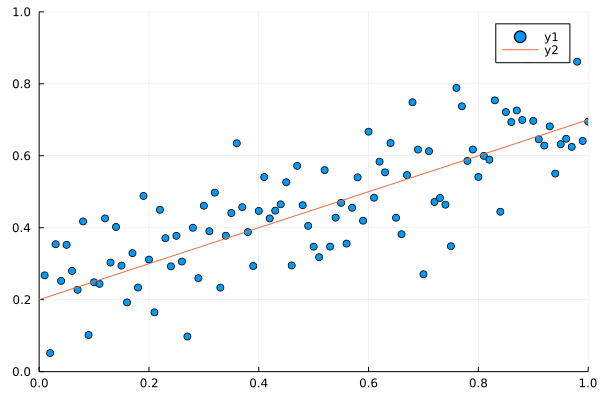

In [42]:
x = CUDA.CuArray(0:0.01:1.0)
nt = length(x)
y = 0.2 .+ 0.5 .* x + 0.1 .* CUDA.randn(nt);
scatter( Array(x), Array(y))
plot!( x -> 0.2 + 0.5x)
xlims!(0,1)
ylims!(0,1)

In [43]:
X = hcat(CUDA.ones(nt), x);

In [68]:
β = X'X \ reshape(X'y, 2, 1) # reshape à cause d'un bug cuda 11.6 corrigé 
# dans la version 11.7

2×1 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 0.21738964109890363
 0.48434929788746206

In [46]:
a = CuArray([1 2 3])

1×3 CuArray{Int64, 2, CUDA.Mem.DeviceBuffer}:
 1  2  3

In [47]:
view(a, 2:3)

2-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
 2
 3

In [48]:
a = CuArray{Float64}([1 2 3])
b = CuArray{Float64}([4 5 6])

map(a) do x
    x + 1
end

1×3 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 2.0  3.0  4.0

In [49]:
reduce(+, a)

6.0

In [50]:
accumulate(+, b; dims=2)

1×3 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 4.0  9.0  15.0

In [51]:
findfirst(isequal(2), a)

CartesianIndex(1, 2)

In [52]:
a = CuArray([1 2 3])
b = CuArray([4 5 6])

map(a) do x
    x + 1
end

a .+ 2b

reduce(+, a)

accumulate(+, b; dims=2)

findfirst(isequal(2), a)

CartesianIndex(1, 2)

# CURAND

In [53]:
CUDA.rand!(a)

1×3 CuArray{Int64, 2, CUDA.Mem.DeviceBuffer}:
 -3999151767418411585  4177302447084939813  -486514589279279442

# CUBLAS

Les opérations entre tableaux alloués sur le GPU sont effectués sur le co-processeur.

In [54]:
a * b'

1×1 CuArray{Int64, 2, CUDA.Mem.DeviceBuffer}:
 1970817630075376073

# CUSOLVER

Certaines fonctions d'algèbre linéaire de LAPACK sont disponibles:

In [66]:
A =  cu([1.80   2.88   2.05  -0.89;
  5.25  -2.95  -0.95  -3.80;
  1.58  -2.69  -2.90  -1.04;
 -1.11  -0.66  -0.59   0.80])

B = cu([9.52  18.47;
 24.35   2.25;
  0.77 -13.28;
 -6.22  -6.21   ])

4×2 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  9.52   18.47
 24.35    2.25
  0.77  -13.28
 -6.22   -6.21

In [69]:
L, ipiv = CUDA.CUSOLVER.getrf!(A)
CUDA.CUSOLVER.getrs!('N', L, ipiv, B)

4×2 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 -16.4208   8.83055
  13.6253  -3.34543
 -15.2035   2.73165
 -29.7264  13.3248

# CUFFT

Pour faire des FFTs sur le GPU, il est nécessaire d'utiliser les `plans` pour allouer l'espace nécessaire sur la carte graphique.

In [70]:
fft = CUFFT.plan_fft(a) 
fft * a

1×3 CuArray{ComplexF64, 2, CUDA.Mem.DeviceBuffer}:
 -3.08364e17+0.0im  -5.84455e18-4.03898e18im  -5.84455e18+4.03898e18im

In [71]:
ifft = CUFFT.plan_ifft(a)
real(ifft * (fft * a))

1×3 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 -3.99915e18  4.1773e18  -4.86515e17

# CUSPARSE

Les formats destinés aux matrices creuses sont aussi disponibles.

In [94]:
A = SymTridiagonal(
                [ 4.0,  10.0,  29.0,  25.0 ,  5.0], [-2.0,  -6.0,  15.0 ,  8.0])

5×5 SymTridiagonal{Float64, Vector{Float64}}:
  4.0  -2.0    ⋅     ⋅    ⋅ 
 -2.0  10.0  -6.0    ⋅    ⋅ 
   ⋅   -6.0  29.0  15.0   ⋅ 
   ⋅     ⋅   15.0  25.0  8.0
   ⋅     ⋅     ⋅    8.0  5.0

In [96]:
using SparseArrays

A = CUDA.CUSPARSE.CuSparseMatrixCSR(sparse(A))

5×5 CuSparseMatrixCSR{Float64, Int32} with 13 stored entries:
  4.0  -2.0    ⋅     ⋅    ⋅ 
 -2.0  10.0  -6.0    ⋅    ⋅ 
   ⋅   -6.0  29.0  15.0   ⋅ 
   ⋅     ⋅   15.0  25.0  8.0
   ⋅     ⋅     ⋅    8.0  5.0

## Les étapes pour porter votre code sur GPU

1. Développez votre application sur votre CPU avec les tabeaux de type `Array`
2. Portez votre application sur GPU en utilisant le type `CuArray`
3. Desactivez "scalar indexing" pour trouver les opérations incompatibles.
4. Ecrivez vos propres kernels CUDA pour remplacer ces opérations.

## Exemple avec une regression linéaire

In [97]:
# squared error loss function
loss(w, b, x, y) = sum(abs2, y - (w*x .+ b)) / size(y, 2)
# get gradient w.r.t to `w`
loss∇w(w, b, x, y) = ForwardDiff.gradient(w -> loss(w, b, x, y), w)
# get derivative w.r.t to `b` (`ForwardDiff.derivative` is
# used instead of `ForwardDiff.gradient` because `b` is
# a scalar instead of an array)
lossdb(w, b, x, y) = ForwardDiff.derivative(b -> loss(w, b, x, y), b)

lossdb (generic function with 1 method)

In [98]:
# proximal gradient descent function
function train(w, b, x, y; lr=0.1)
    w -= lmul!(lr, loss∇w(w, b, x, y))
    b -= lr * lossdb(w, b, x, y)
    return w, b
end

train (generic function with 1 method)

Version CPU

In [99]:
function cpu_test(n = 1000, p = 100, iter = 100)
    x = randn(n, p)'
    y = sum(x[1:5,:]; dims=1) .+ randn(n)' * 0.1
    w = 0.0001 * randn(1, p)
    b = 0.0
    for i = 1:iter
       w, b = train(w, b, x, y)
    end
    return loss(w,b,x,y)
end

cpu_test (generic function with 4 methods)

In [100]:
@time cpu_test()

  3.689814 seconds (9.96 M allocations: 792.290 MiB, 6.31% gc time, 88.52% compilation time)


0.008917112031392097

### Version GPU

In [101]:
function gpu_test( n = 1000, p = 100, iter = 100)
    x = randn(n, p)'
    y = sum(x[1:5,:]; dims=1) .+ randn(n)' * 0.1
    w = 0.0001 * randn(1, p)
    b = 0.0
    x = CuArray(x)
    y = CuArray(y)
    w = CuArray(w)
    
    for i = 1:iter
       w, b = train(w, b, x, y)
       
    end
    return loss(w,b,x,y)
end

gpu_test (generic function with 4 methods)

In [102]:
@time gpu_test()

 20.653892 seconds (52.87 M allocations: 2.721 GiB, 5.82% gc time, 87.69% compilation time)


0.010232953359950435

In [103]:
@btime cpu_test( 10000, 100, 100)

  4.277 s (17322 allocations: 2.68 GiB)


0.009700305378332084

In [104]:
@btime gpu_test( 10000, 100, 100);

  381.641 ms (282513 allocations: 47.61 MiB)


# Noyaux CUDA

L'écriture directe de noyaux CUDA est possible, cependant:
- les allocations sont interdites,
- pas d'entrées-sorties donc pas d'affichage,
- si votre code n'est pas typé correctement, le code compilé sera peu performant.

Programmer vos noyaux de manière incrémentale, en les gardant le plus simple possible et en vérifiant
soigneusement que le résultat escompté est correct.

In [105]:
a = CUDA.zeros(1024)

function kernel(a)
    i = threadIdx().x
    a[i] += 1
    return
end

@cuda threads=length(a) kernel(a)

CUDA.HostKernel{typeof(kernel), Tuple{CuDeviceVector{Float32, 1}}}(kernel, CuContext(0x0000000003d646d0, instance ab6ddf66a1b5235), CuModule(Ptr{Nothing} @0x0000000051ef91e0, CuContext(0x0000000003d646d0, instance ab6ddf66a1b5235)), CuFunction(Ptr{Nothing} @0x000000005212d900, CuModule(Ptr{Nothing} @0x0000000051ef91e0, CuContext(0x0000000003d646d0, instance ab6ddf66a1b5235))), CUDA.KernelState(Ptr{Nothing} @0x00007f5220c00000))

In [106]:
a = CUDA.rand(Int, 1000)

1000-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
  5837161489375825610
  3249834628757770091
 -5445612182052022760
 -3923169803801740765
   733695658409288933
  4087743593613329616
 -8043406591028943260
 -1679676387806972955
  5868368425283356571
 -8870067186870587342
 -8806292451624114506
  2667895617132920446
  5755721119752581421
                    ⋮
 -3147517702367032313
  8824339326254996660
  5417925738279581962
 -7419932983391578861
 -2735502713972005690
 -5042777480891349324
  6873199818063300975
  7116077105598374239
  7953475190154515888
  6044645330568083067
  1660400826189220102
   380899770619687558

In [107]:
norm(a)

1.684001235807264e20

In [108]:
@btime norm($a)

  51.287 μs (88 allocations: 4.53 KiB)


1.684001235807264e20

In [109]:
@btime norm($(Array(a)))

  1.671 μs (0 allocations: 0 bytes)


1.6840012358072638e20

La fonction `norm` est bien plus rapide exécutée sur le CPU

In [110]:
CUDA.allowscalar(false)

In [111]:
a = CuArray(1:9_999_999);

In [112]:
@time a .+ reverse(a);

  1.998018 seconds (5.09 M allocations: 272.327 MiB, 3.43% gc time, 83.51% compilation time)


Pour effectuer cette dernière instruction, vous avez besoin de
programmer deux noyaux.  La macro `@time` n'est pas adéquate pour
évaluer la performance car on a affaire à une opération de type
"lazy". C'est à dire que l'expression est programmée sur le GPU
mais pas exécutée. Elle le sera lorsque vous transférerez le résultat
vers le CPU. Vous pouvez utiliser `@sync` ou `@time` du package
`CUDA`.

In [113]:
@time CUDA.@sync a .+ reverse(a);

  0.002643 seconds (112 allocations: 6.453 KiB)


In [114]:
CUDA.@time a .+ reverse(a);

  0.002548 seconds (112 CPU allocations: 6.453 KiB) (2 GPU allocations: 152.588 MiB, 0.79% memmgmt time)


In [115]:
@btime CUDA.@sync $a .+ reverse($a);

  2.365 ms (110 allocations: 6.39 KiB)


In [116]:
@btime CUDA.@sync $(Array(a)) .+ reverse($(Array(a)));

  56.495 ms (4 allocations: 152.59 MiB)


## Aide au développement

Vous avez quelques macros disponibles pour vous aidez à implémenter vos noyaux:

In [117]:
kernel() = (@cuprintln("foo"); return)

kernel (generic function with 2 methods)

In [118]:
@cuda kernel()

CUDA.HostKernel{typeof(kernel), Tuple{}}(kernel, CuContext(0x0000000003d646d0, instance ab6ddf66a1b5235), CuModule(Ptr{Nothing} @0x0000000041610b80, CuContext(0x0000000003d646d0, instance ab6ddf66a1b5235)), CuFunction(Ptr{Nothing} @0x000000005443dc60, CuModule(Ptr{Nothing} @0x0000000041610b80, CuContext(0x0000000003d646d0, instance ab6ddf66a1b5235))), CUDA.KernelState(Ptr{Nothing} @0x00007f5220c00000))

foo


In [119]:
kernel() = (@cuprintln("bar"); return)

kernel (generic function with 2 methods)

In [120]:
@cuda kernel()

CUDA.HostKernel{typeof(kernel), Tuple{}}(kernel, CuContext(0x0000000003d646d0, instance ab6ddf66a1b5235), CuModule(Ptr{Nothing} @0x00000000528086e0, CuContext(0x0000000003d646d0, instance ab6ddf66a1b5235)), CuFunction(Ptr{Nothing} @0x00000000527b2e90, CuModule(Ptr{Nothing} @0x00000000528086e0, CuContext(0x0000000003d646d0, instance ab6ddf66a1b5235))), CUDA.KernelState(Ptr{Nothing} @0x00007f5220c00000))

Attention, exécuter plusieurs noyaux CUDA à la suite prend du temps
car il y a un temps de lattence plus important que sur CPU.

In [121]:
a = CuArray(1:9_999_999)
c = similar(a)
c .= a .+ reverse(a);

bar


In [122]:
function vadd_reverse(c, a, b)
    i = threadIdx().x
    if i <= length(c)
        @inbounds c[i] = a[i] + reverse(b)[i]
    end
    return
end

vadd_reverse (generic function with 1 method)

Essayons de remplacer la fonction `reverse`

In [123]:
function vadd_reverse(c, a, b)
    
    i = threadIdx().x
    if i <= length(c)
        @inbounds c[i] = a[i] + b[end - i + 1]
    end
    return
end

vadd_reverse (generic function with 1 method)

Cela ne fonctionne pas car on n'itère pas sur un tableau alloué sur
un GPU de la même manière qu'un tableau alloué sur CPU.

In [124]:
@cuda threads = length(a) vadd_reverse(c, a, a)

LoadError: CUDA error: invalid argument (code 1, ERROR_INVALID_VALUE)

Les fonctions `blockIdx` et `threadIdx` sont disponibkes pour vous aider:

In [125]:
attribute(device(), CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)

1024

In [126]:
function vadd_reverse(c, a, b)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if i <= length(c)
        @inbounds c[i] = a[i] + b[end - i + 1]
    end
    return
end

vadd_reverse (generic function with 1 method)

Le noyau construit est plus rapide que la fonction `reverse` initialement utilisée:

In [ ]:
@btime CUDA.@sync @cuda threads=1024 blocks=length($a)÷1024+1 vadd_reverse($c, $a, $a)

In [ ]:
@btime CUDA.@sync $a .+ reverse($a);

Vous pouvez automatiser la configuration du noyau aux caractéristiques de votre carte.

In [ ]:
function configurator(kernel)
    config = launch_configuration(kernel.fun)
    threads = min(length(a), config.threads)
    blocks = cld(length(a), threads)
    return (threads=threads, blocks=blocks)
end

In [ ]:
@cuda config=configurator vadd_reverse(c, a, a)